# Mean-Variance Optimization

In [1]:
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like # added to avoid 
#import quandl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as sco
import plotly
# from plotly import graph_objs as go
import cufflinks as cf
# from cvxopt import matrix, solvers
from scipy import stats
import statsmodels.api as sm
from datetime import *
from dateutil.relativedelta import relativedelta
from nsepy import get_history

get_ipython().run_line_magic('matplotlib', 'inline')
#%config InlineBackend.figure_format = 'retina'

In [2]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    """
    This function will calculate the returns and volatility, 
    and to make it as an annualised calculation. 
    252 is the number of trading days in one year.
    https://faculty.washington.edu/ezivot/econ424/portfolioTheoryMatrix.pdf
    """
    returns = np.dot(mean_returns,weights.T ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

In [3]:
def asset_implied_return(market_cap, asset_daily_return, risk_free_rate):
    """
    This function calculate the implied return of each asset by 
    (implied_excess)PI = lambda* covariance matrix * market_cap_weight
    where: 
    lambda = (benchmark_return - risk_free_rate)/variance_of_benchmark
    and In this case the benchmark is the market capitalization weighted portfolio

    """
    bm_weight  = market_cap/np.sum(market_cap)
    
    mean = asset_daily_return.mean()
    cov = asset_daily_return.cov()
    
    bm_std, bm_return = portfolio_annualised_performance(bm_weight,mean, cov)

    lmbda = (bm_return- risk_free_rate)/np.square(bm_std)
    
    implied_excess= np.dot(np.dot(lmbda, cov), bm_weight) 
    
    implied_daily = (implied_excess*252 + risk_free_rate)/252
    
    return implied_daily, bm_return


In [4]:
def random_portfolios_ro(num_portfolios, market_cap, asset_daily_return, risk_free_rate, target_beta, upper_cap, lower_cap):
    """
    This function will generate portfolios with random weights assigned to each stock, 
    num_portfolios argument is how many random portfolios you want to generate.
    It calculate the all the common performance and risk assessment:
        - std of the return
        - annualized_reaturn
        - Sharpe Ratio (portfolio_return - risk_free_rate) / portfolio_std_dev
        - beta = implied_excess/(bm_return- risk_free_rate)
    """

    weights_record = []
    #mean_returns = asset_daily_return.mean()
    
    implied_daily, bm_annual_return = asset_implied_return(market_cap, asset_daily_return, risk_free_rate)
    cov_matrix = asset_daily_return.cov()
    
    ncol = implied_daily.shape[0]
    results = np.zeros((4,num_portfolios))
    count = 0
    
    for i in range(num_portfolios):
        weights = np.random.random(ncol)
        weights /= np.sum(weights) #% of the weight with sum = 1  
            
        if ((weights - lower_cap) >= 0).all() and ((weights - upper_cap) <= 0).all():
            
            portfolio_std_dev, portfolio_implied_return = portfolio_annualised_performance(weights, implied_daily, cov_matrix)
            
            portfolio_implied_beta = (portfolio_implied_return - risk_free_rate)/(bm_annual_return - risk_free_rate)
            
            
            if portfolio_implied_beta <= target_beta: 
                results[0,count] = portfolio_std_dev
                results[1,count] = portfolio_implied_return
                results[2,count] = (portfolio_implied_return - risk_free_rate) / portfolio_std_dev # Sharpe Ratio
                results[3,count] = portfolio_implied_beta
            
                weights_record.append(weights)
                count += 1
    
    return results[:,0:count], weights_record, count

In [5]:
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.05,0.4)
    bounds = tuple(bound for asset in range(num_assets))
    #bounds = ((0.05, 0.051), (0.05, 0.4), (0.05, 0.4), (0.05, 0.4), (0.05, 0.4), (0.05, 0.4))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [6]:
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.05,0.4)
    bounds = tuple(bound for asset in range(num_assets))
    #bounds = ((0.05, 0.051), (0.05, 0.4), (0.05, 0.4), (0.05, 0.4), (0.05, 0.4), (0.05, 0.4))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result

In [7]:
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.05,0.4)
    bounds = tuple(bound for asset in range(num_assets))
    #bounds = ((0.05, 0.051), (0.05, 0.4), (0.05, 0.4), (0.05, 0.4), (0.05, 0.4), (0.05, 0.4))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result 

#minimize variation given return value

def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

In [8]:
def display_calculated_ef_ro(asset_daily_return, num_portfolios, market_cap, risk_free_rate, target_beta = 10, upper_cap = np.repeat(1, 100),
                             lower_cap = np.repeat(0, 100)):
    
    ncol = asset_daily_return.shape[1]
    upper_cap = upper_cap[0:ncol]
    lower_cap = lower_cap[0:ncol]
    
    results,_,_ = random_portfolios_ro(num_portfolios, market_cap, asset_daily_return, risk_free_rate, target_beta, upper_cap,lower_cap)
    
    implied_daily,_ = asset_implied_return(market_cap, asset_daily_return, risk_free_rate)
    cov_matrix = asset_daily_return.cov()
    
    max_sharpe = max_sharpe_ratio(implied_daily, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], implied_daily, cov_matrix) # x is the weight
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=asset_daily_return.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,3)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T

    min_vol = min_variance(implied_daily, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], implied_daily, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=asset_daily_return.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,3)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
#     allocations=pd.concat([max_sharpe_allocation,min_vol_allocation])
    
    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,3))
    print ("Annualised Volatility:", round(sdp,3))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,3))
    print ("Annualised Volatility:", round(sdp_min,3))
    print ("\n")
    print (min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, rp, 50)
    efficient_portfolios = efficient_frontier(implied_daily, cov_matrix, target)
    plt.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    plt.title('Calculated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)
    
    return (max_sharpe_allocation, min_vol_allocation, rp,sdp,rp_min,sdp_min)


In [9]:
def Nifty50_returns_cal(startTime, endtTime):
    data = get_history(symbol="NIFTY 50", start= datetime.strptime(startTime, '%Y-%m-%d').date(), 
                       end=datetime.strptime(endTime, '%Y-%m-%d').date(), index=True)
    NIFTY50return=(data['Close'][-1]-data['Close'][0])/data['Close'][0]
    NIFTY50_AnnualizedReturn=(1+NIFTY50return)**0.5-1
    return NIFTY50_AnnualizedReturn

In [10]:
def multi_csvs_newdata(pGOLDBEES,pHNGSNGBEES,pICICINIFTY,pICICISENSX,pLICNETFGSC, pM100,pN100,pSETFNN50):
    GOLDBEES = pd.read_csv(pGOLDBEES)
    HNGSNGBEES = pd.read_csv(pHNGSNGBEES)
    ICICINIFTY = pd.read_csv(pICICINIFTY)
    ICICISENSX = pd.read_csv(pICICISENSX)
    LICNETFGSC = pd.read_csv(pLICNETFGSC)
    M100 = pd.read_csv(pM100)
    N100 = pd.read_csv(pN100)
    SETFNN50 = pd.read_csv(pSETFNN50)
 
    list_of_etf=[GOLDBEES,HNGSNGBEES, ICICINIFTY,ICICISENSX, LICNETFGSC,M100, N100,SETFNN50]
    list_of_etf_names=['GOLDBEES','HNGSNGBEES', 'ICICINIFTY','ICICISENSX', 'LICNETFGSC','M100', 'N100','SETFNN50']
    for e in list_of_etf:
        e['Date'] = pd.to_datetime(e['Date'])
        e.set_index('Date', inplace = True)
    indian_etf = pd.concat(list_of_etf,axis=1,keys=list_of_etf_names)
    # Only keep the close price
    indian_etf_close = indian_etf.xs(key = 'Close Price' , axis=1, level=1)
    # Fill all the NaN with the previous price 
    indian_etf_close.fillna(method='ffill',inplace = True)
    # Get the returns data by taking the percent change of the close price
    indian_etf_close=indian_etf_close.replace(',', '', regex=True)
    indian_etf_close=indian_etf_close.astype('float64')
    indian_etf_return = indian_etf_close.pct_change()
    return indian_etf_return

In [11]:
def importExcel_CalReturns(filePath, paths1):
    list_of_etf=[]
    # Read the file from its path
    xls = pd.ExcelFile(filePath)
    # Get the content of each spreadsheet and concate them together
    for sheet_name in xls.sheet_names:
        sheet_name = xls.parse(sheet_name)
        list_of_etf.append(sheet_name)
    for e in list_of_etf:
        e['Date'] = pd.to_datetime(e['Date'])
        e.set_index('Date', inplace = True)

    indian_etf = pd.concat(list_of_etf,axis=1,keys=xls.sheet_names)
    # Only keep the close price
    indian_etf_close = indian_etf.xs(key = 'CLOSE', axis=1, level=1)
    # Fill all the NaN with the previous price 
    indian_etf_close.fillna(method='ffill',inplace = True)
    # Get the returns data by taking the percent change of the close price
    indian_etf_return = indian_etf_close.pct_change()
    pGOLDBEES,pHNGSNGBEES,pICICINIFTY,pICICISENSX,pLICNETFGSC, pM100,pN100,pSETFNN50=paths1[0],paths1[1],paths1[2],paths1[3],paths1[4],paths1[5],paths1[6],paths1[7]
    indian_etf_return_new=multi_csvs_newdata(pGOLDBEES,pHNGSNGBEES,pICICINIFTY,pICICISENSX,pLICNETFGSC, pM100,pN100,pSETFNN50)
    indian_etf_return=indian_etf_return.append(indian_etf_return_new)
    
    return indian_etf_return
    

In [12]:
def Select_Result(selection, indian_etf_return, etfList, all_market_cap, startTime, endTime, risk_free_rate, num_portfolios, target_beta, upper_cap, lower_cap):
    selection_1_return = indian_etf_return[selection]
    selection_1_return.dropna(inplace = True)
    # Select the look-back period 
    asset_daily_return = selection_1_return.loc[startTime:endTime]

    market_cap = np.array([all_market_cap[j+'mc'] for j in selection])
    # Get the MVO result of each preference
    max_sharpe_allocation, min_vol_allocation, retS,volS,retV,volV=display_calculated_ef_ro(asset_daily_return, num_portfolios,market_cap,
                                                                                            risk_free_rate, target_beta, upper_cap, lower_cap)
    return max_sharpe_allocation, min_vol_allocation, retS,volS,retV,volV

In [13]:
def self_portfolio_opt(indian_etf_return, etfList, all_market_cap, startTime, endTime, risk_free_rate, num_portfolios, target_beta,
                       upper_cap, lower_cap):
    data_day_list=[]
    maxSR_allocations_list=[]
    minVol_allocations_list=[]
    for i in range(len(etfList)):
        max_sharpe_allocation, min_vol_allocation, retS,volS,retV,volV=Select_Result(etfList[i], indian_etf_return, etfList, all_market_cap, startTime, endTime, 
                                                       risk_free_rate, num_portfolios, target_beta, upper_cap, lower_cap)
        
        data_day = pd.DataFrame([[retS,volS,retV,volV]])
        data_day_list.append(data_day)
        # Weights of the result
        maxSR_allocations_list.append(max_sharpe_allocation)
        minVol_allocations_list.append(min_vol_allocation)
        
    # Result of the best return result we got   
    final_data_day = pd.concat(data_day_list)
    final_data_day.index=['ALL 6 ETF','W/O N100','W/O N100 and HangSeng']
    final_data_day.columns=['Annualised Return for Max SR','Annualised Volatility for Max SR',
                            'Annualised Return for Min Vol','Annualised Volatility for Min Vol']
#     NIFTY50_AnnualizedReturn= Nifty50_returns_cal(startTime, endTime)
#     temp=pd.DataFrame([[NIFTY50_AnnualizedReturn,np.nan,NIFTY50_AnnualizedReturn,np.nan]],columns=final_data_day.columns,index=['NIFTY50_AnnualizedReturn'])
#     final_data_day=final_data_day.append(temp)
#     final_data_day=final_data_day.round(3)
    
    # Result of the weights
    final_weights = pd.concat(maxSR_allocations_list+minVol_allocations_list)
    
    final_weights.index=pd.MultiIndex.from_product([[endTime],['Max Sharpe Ratio','Min Volatility'],['ALL 6 ETF','W/O N100','W/O N100 and HangSeng']])
    return final_weights


In [14]:
def compare(previous, current):  
    result=current.copy(deep=True)
    if previous is not None:
        result.astype(str)
        for i in range(0, len(current)):
            for j in range(len(current.columns)):
                result.iloc[i,j]=str(current.iloc[i,j])+'('+str(round(float(current.iloc[i,j])- float(previous.iloc[i,j]),3))+')'
                if np.isnan(current.iloc[i,j]):
                    result.iloc[i,j]=np.nan
    return result

In [15]:
def gen_dates(b_date, days):
    day = timedelta(days=1)
    for i in range(days):
        yield b_date + day*i


def get_date_list(start, end):
    start = datetime.strptime(start, "%Y-%m-%d")
    if end is None:
        end = datetime.now()
    else:
        end = datetime.strptime(end, "%Y-%m-%d")
    data = []
    for d in gen_dates(start, (end-start).days):
        data.append(d)
    return data

In [16]:
def plot_returns(returns):
    plotly.tools.set_credentials_file(username='whdhz218', api_key='UPPielFzanNcVzRAJr0Y')
    returns.iplot()

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.214
Annualised Volatility: 0.155


            HNGSNGBEES  ICICISENSX   M100  SETFNN50  ICICINIFTY  N100
allocation      24.589       9.744  6.909       5.0      13.757  40.0
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.152
Annualised Volatility: 0.121


            HNGSNGBEES  ICICISENSX    M100  SETFNN50  ICICINIFTY    N100
allocation       8.362         5.0  29.329     5.833      29.249  22.227
--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.175
Annualised Volatility: 0.194


            HNGSNGBEES  ICICISENSX    M100  SETFNN50  ICICINIFTY
allocation        40.0      19.973  12.212     5.067      22.747
----------------------------------------------

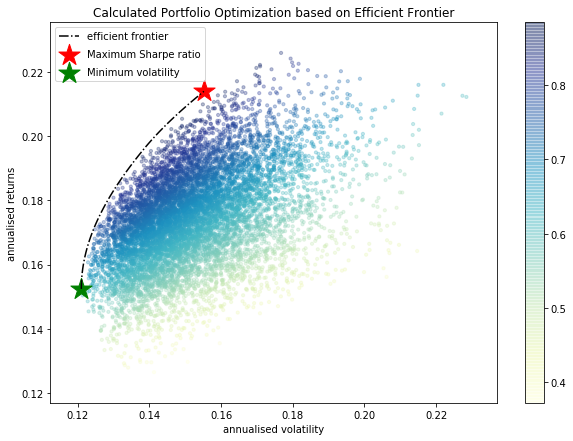

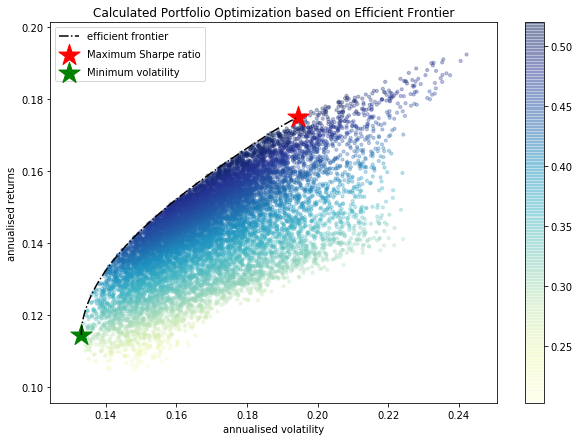

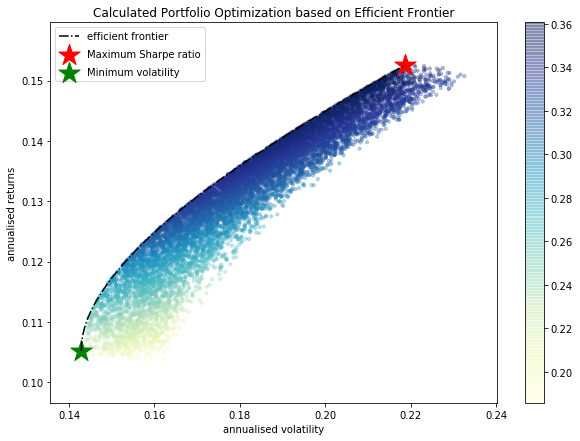

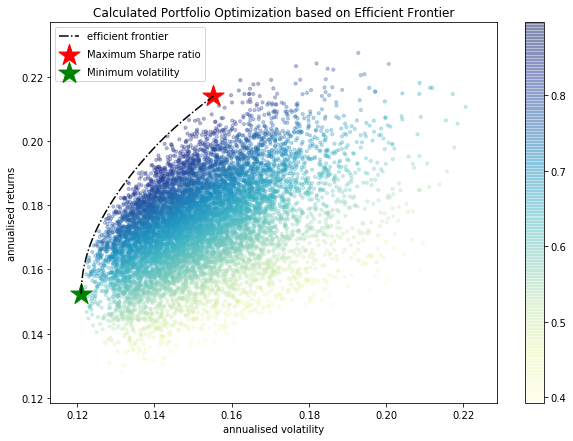

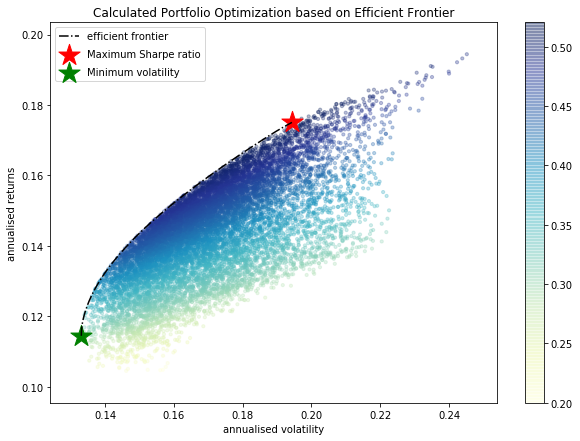

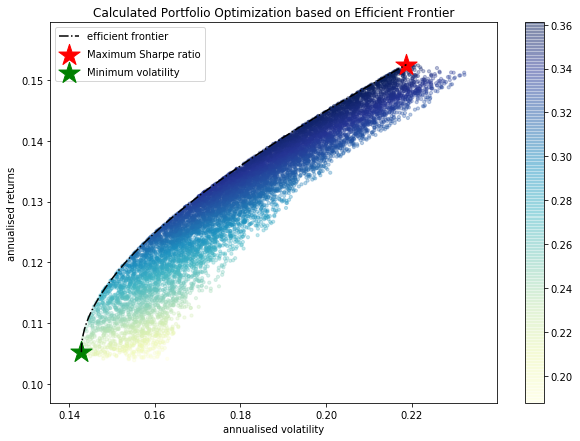

In [17]:
filePath='D:/Graduate/ARATZ CAPITAL LLC/data/index11.02.19-2.xlsx'

# list_of_etf=[GOLDBEES,HNGSNGBEES, ICICINIFTY, LICNETFGSC,M100, N100,SETFNN50,ICICISENSX]
# list_of_etf_names=['GOLDBEES','HNGSNGBEES', 'ICICINIFTY', 'LICNETFGSC','M100', 'N100','SETFNN50','ICICISENSX']

full_names= ['GOLDBEES','HNGSNGBEES', 'ICICINIFTY', 'ICICISENSX','LICNETFGSC','M100', 'N100','SETFNN50']
pGOLDBEES,pHNGSNGBEES,pICICINIFTY,pICICISENSX,pLICNETFGSC, pM100,pN100,pSETFNN50=None,None,None,None,None,None,None,None
paths=[pGOLDBEES,pHNGSNGBEES,pICICINIFTY,pICICISENSX,pLICNETFGSC, pM100,pN100,pSETFNN50]


today="26-05-2019"
for name,j in zip(full_names,range(len(paths))):
    paths[j]="D:/Graduate/ARATZ CAPITAL LLC/data/12-02-2019-TO-"+today+name+"ALLN.csv"

etfs6=['HNGSNGBEES', 'ICICISENSX','M100', 'SETFNN50', 'ICICINIFTY', 'N100']
etfs5=['HNGSNGBEES', 'ICICISENSX','M100', 'SETFNN50', 'ICICINIFTY']
etfs4=['ICICISENSX','M100', 'SETFNN50', 'ICICINIFTY']
etfList=[etfs6,etfs5,etfs4]

endTimeList=get_date_list('2018-09-01','2018-09-03')
risk_free_rate = 0.0735
num_portfolios = 25000
target_beta = 10
upper_cap = np.repeat(0.4, 6)
lower_cap = np.repeat(0.05, 6)

all_market_cap={'HNGSNGBEESmc':652933.05,
                'ICICISENSXmc':278677.18,
                'M100mc':17696.05,
                'SETFNN50mc':44715.44,
                'ICICINIFTYmc':231527.68, 
                'N100mc':1491558.15}

previous=None
finalResult=pd.DataFrame()

# The result for 1st of each month from Jan to Apr 2019
for endTime in endTimeList:
#     startTime='-'.join([str(int(endTime.split('-')[0])-2),endTime.split('-')[1],endTime.split('-')[2]])  #two years ago
#     startTime='2018-09-01'
    startTime='2015-03-27'
    endTime='{:%Y-%m-%d}'.format(endTime)
    indian_etf_return=importExcel_CalReturns(filePath,paths)
    current=self_portfolio_opt(indian_etf_return, etfList, all_market_cap, startTime, endTime, risk_free_rate, num_portfolios, target_beta,
                               upper_cap, lower_cap)
    res=compare(previous,current)
#     res.to_excel(writer,'"'+endTime+'"')
    finalResult=finalResult.append(res)
    previous=current.copy(deep=True)

In [18]:
finalResult

HNGSNGBEES   ICICINIFTY  \
2018-09-01 Max Sharpe Ratio ALL 6 ETF                   24.589       13.757   
                            W/O N100                        40       22.747   
                            W/O N100 and HangSeng          NaN           40   
           Min Volatility   ALL 6 ETF                    8.362       29.249   
                            W/O N100                    12.121       36.783   
                            W/O N100 and HangSeng          NaN           40   
2018-09-02 Max Sharpe Ratio ALL 6 ETF              24.589(0.0)  13.757(0.0)   
                            W/O N100                 40.0(0.0)  22.747(0.0)   
                            W/O N100 and HangSeng          NaN    40.0(0.0)   
           Min Volatility   ALL 6 ETF               8.362(0.0)  29.249(0.0)   
                            W/O N100               12.121(0.0)  36.783(0.0)   
                            W/O N100 and HangSeng          NaN    40.0(0.0)   

                                                    ICICISENSX         M100  \
2018-09-01 Max Sharpe Ratio ALL 6 ETF                    9.744        6.909   
                            W/O N100                    19.973       12.212   
                            W/O N100 and HangSeng           40       11.117   
           Min Volatility   ALL 6 ETF                        5       29.329   
                            W/O N100                         5       37.959   
                            W/O N100 and HangSeng        5.615           40   
2018-09-02 Max Sharpe Ratio ALL 6 ETF               9.744(0.0)   6.909(0.0)   
                            W/O N100               19.973(0.0)  12.212(0.0)   
                            W/O N100 and HangSeng    40.0(0.0)  11.117(0.0)   
           Min Volatility   ALL 6 ETF                 5.0(0.0)  29.329(0.0)   
                            W/O N100                  5.0(0.0)  37.959(0.0)   
                            W/O N100 and HangSeng   5.615(0.0)    40.0(0.0)   

                                                          N100     SETFNN50  
2018-09-01 Max Sharpe Ratio ALL 6 ETF                       40            5  
                            W/O N100                       NaN        5.067  
                            W/O N100 and HangSeng          NaN        8.883  
           Min Volatility   ALL 6 ETF                   22.227        5.833  
                            W/O N100                       NaN        8.137  
                            W/O N100 and HangSeng          NaN       14.385  
2018-09-02 Max Sharpe Ratio ALL 6 ETF                40.0(0.0)     5.0(0.0)  
                            W/O N100                       NaN   5.067(0.0)  
                            W/O N100 and HangSeng          NaN   8.883(0.0)  
           Min Volatility   ALL 6 ETF              22.227(0.0)   5.833(0.0)  
                            W/O N100                       NaN   8.137(0.0)  
                            W/O N100 and HangSeng          NaN  14.385(0.0)

In [19]:
def efficient_monthly(asset_daily_return, target_return):
    """
    returns specified number of efficient portfolio's monthly return, std and allocations
    The reason to choose monthly is for the ease of adding additional money to the portfolio monthly
    """

    implied_daily, bm_return = asset_implied_return(market_cap, asset_daily_return, risk_free_rate)
    cov_matrix = asset_daily_return.cov()
    
    efficient_portfolios = efficient_frontier(implied_daily, cov_matrix, target_return)
    efficient_stds = [p['fun'] for p in efficient_portfolios]
    efficient_allocations = [p['x'] for p in efficient_portfolios]
    
    nallocation = asset_daily_return.shape[1]
    num_target_portfolios = len(target_return)
    
    efficient_portfolios_monthly = np.zeros((num_target_portfolios,(2 + nallocation)))
    efficient_portfolios_monthly[:,0] = target_return/12
    efficient_portfolios_monthly[:,1] = efficient_stds/np.sqrt(12)
    efficient_portfolios_monthly[:,2:(2+nallocation)] = efficient_allocations
    
    return efficient_portfolios_monthly

In [20]:
# efficient_portfolios_monthly = efficient_monthly(asset_daily_return, target_return)
# target_return = np.linspace(0.146, 0.344, 100)
# efficient_portfolios = efficient_frontier(implied_daily, cov_matrix, target_return)
# efficient_stds = [p['fun'] for p in efficient_portfolios]
# efficient_allocations = [p['x'] for p in efficient_portfolios]

In [21]:
def MC_simulation(asset_daily_return, target_return, T_in_month, sim = 5000,initial_wealth = 1, additional_wealth_monthly = 0):
    
    """
    Monte Carlo Simulation of the specified number of portfolios
    """
    efficient_portfolios_monthly = efficient_monthly(asset_daily_return, target_return)
    
    wealth_in_T = np.zeros((len(target_return),sim))
    
    for p in range(len(efficient_portfolios_monthly)):
        for i in range(sim):
            monthly_returns = np.random.normal(efficient_portfolios_monthly[p,0], efficient_portfolios_monthly[p,1],T_in_month)+1
            cum_wealth = [initial_wealth]
        
            for x in monthly_returns:
                cum_wealth.append(cum_wealth[-1]*x + additional_wealth_monthly)
        
            wealth_in_T[p,i] = cum_wealth[-1]
     
        wealth_in_T.sort(axis = 1)
    
    return wealth_in_T 

In [22]:
# target_return = np.linspace(0.146, 0.344, 100) # needs to be np array form,not list
# T_in_month = 6 # in month
# sim = 5000
# initial_wealth = 1
# additional_wealth_monthly = 0
# np.random.seed(101)
# wealth_in_T = MC_simulation(asset_daily_return, target_return, T_in_month, sim, initial_wealth , additional_wealth_monthly )

In [23]:
def all_simulation_visualization(percentiles, asset_daily_return, target_return, T_in_month, sim = 5000, initial_wealth = 1, additional_wealth_monthly = 0):
    
    wealth_in_T = MC_simulation(asset_daily_return, target_return, T_in_month, sim ,
                  initial_wealth , additional_wealth_monthly )
    
    print(wealth_in_T.shape)
    
    print(percentiles)
    percentiles_col = [int(pct * sim/len(target_return)) for pct in percentiles]
    print(percentiles_col)

    percentiles_wealth = wealth_in_T[:,percentiles_col]
    
    
    mean_percentiles_wealth = pd.DataFrame({'mean_return':percentiles_wealth.mean(axis=0), 
                                            'std_return':percentiles_wealth.std(axis=0)},
                                           index = percentiles)
    print(mean_percentiles_wealth)
    
    
    fig, ax = plt.subplots(figsize = (20,10))
    
    for i in range(len(percentiles)):
        sns.distplot(percentiles_wealth[:,i],bins=20, ax= ax)
    
    plt.legend(labels = ['{0} percentile spread of all portfolios'.format(i) for i in percentiles],
          fontsize=15)
    plt.show()